In [51]:
import numpy as np
import random
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pymongo
import json
from sklearn.metrics import mean_squared_error
from random import sample
import time
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [2]:
#從xlsx匯入資料
rec_data= pd.read_excel(r'./melt_data.xlsx',encoding='utf-16',index_col=0)

In [4]:
#sample train test data

train_idx=sample(rec_data.index.to_list(),int(len(rec_data)*0.7))
train_data=rec_data.loc[train_idx]
test_tmp=rec_data.index.isin(train_idx)
test_data=rec_data[~test_tmp]

In [12]:
train_data.head()

,user,variable,value
104531,1220,台北富邦-台灣大哥大悠遊聯名卡,0
292297,907,美國運通-長榮航空簽帳白金卡,0
450779,449,臺灣銀行-導盲犬認同卡,0
286434,342,星展銀行-飛行世界卡,0
79959,489,元大銀行-樂遊卡,0


In [11]:
test_data.head()

,user,variable,value
0,0,三信銀行-VISA白金卡,0
2,2,三信銀行-VISA白金卡,0
4,4,三信銀行-VISA白金卡,0
5,5,三信銀行-VISA白金卡,0
6,6,三信銀行-VISA白金卡,0


In [45]:
#melt data to df and fillna with 0
train_df=train_data.pivot_table(values='value',index='user',columns='variable').fillna(0)
train_df.head()

variable,三信銀行-VISA白金卡,上海商銀-TeresaCard,上海商銀-小小兵Bello回饋卡,上海商銀-簡單卡,中國信託-ANA聯名卡,中國信託-LINE Pay卡,中國信託-MUJI無印良品聯名卡,中國信託-Yahoo聯名卡,中國信託-中信兄弟聯名卡,中國信託-中信商旅鈦金卡,...,華南銀行-i網購生活卡,華南銀行-享利樂活Combo卡,華南銀行-大甲媽祖認同卡,華南銀行-旅鑽商務御璽卡,華南銀行-美饌紅利卡,華南銀行-超級現金回饋卡,遠東商銀-Bankee信用卡,遠東商銀-快樂信用卡,陽信銀行-一卡通聯名鈦金卡,陽信銀行-曜晶卡
user,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
indices = pd.Series(train_df.columns)   #所有卡series
#card_index_list=indices[train_df.loc[1]==1]

print(train_df.columns[train_df.loc[0]==1].to_list())
print(train_df.columns[train_df.loc[1]==1].to_list())

['中國信託-LINE Pay卡', '台新銀行-FlyGo卡']
['中國信託-LINE Pay卡', '台新銀行-@GoGo iCash御璽卡', '花旗銀行-新世代花旗饗樂生活悠遊卡']


In [75]:
#test data total card
len(test_data[test_data['value']==1])/len(test_data)

0.022097786725948296

# Item_Based_Evaluate

In [24]:
#item_base_rec
def CF_Item_Based_Evaluate(train,TopN):
    start_time = time.time()

    #imput data type:df
    #轉置df
    traindata=train
    traindata_T=traindata.T
    #計算各卡間的相似度
    card_sim=cosine_similarity(traindata_T,traindata_T)
    
    #找出已持有卡index
    item_rec_list={}
    for user in traindata.index:
           #所有卡series
        my_card=traindata.columns[traindata.loc[user]==1].to_list()#找持有卡
        rating=pd.Series(traindata.loc[1].values)
        indices = pd.Series(traindata_T.index)
        card_index_list=[indices[indices == name].index[0] for name in my_card]  #找出各卡index
        weighted_card_rec=np.zeros(len(traindata_T.index))   #創全0且為卡片數量長度的array
        for  i in card_index_list:
            weighted_card_rec +=card_sim[i]*rating[i]      #將持有卡於其他卡的相似度相加成推薦權重
        #排列相似度最高前TopN名卡片
        weighted_score=pd.Series(weighted_card_rec).sort_values(ascending = False)
        TopN_indexes=weighted_score.iloc[len(my_card):len(my_card)+TopN].index
        rec_card=[]
        for i in TopN_indexes:
            rec_card.append(indices[i])
        item_rec_list[user]=rec_card
    #calculate TopN in test_data
    #test_data user
    total_precision=0
    total_hit =0
    result={}

    for user in list(set(test_data['user'])):
        user_df=test_data[test_data['user']==user]
        user_df_hold=user_df[user_df['value']==1]['variable'].values
        hit=sum([1 for item in item_rec_list[user] if item in user_df_hold])
        precision=hit/TopN
        
        total_precision +=precision
        total_hit +=hit
    result['Precision']=total_precision/len(set(test_data['user']))
    
    result['Hit']=total_hit/len(set(test_data['user']))
    #exec_time= "--- %s seconds ---" % (time.time() - start_time)
    exec_time= (time.time() - start_time)


    return result,exec_time


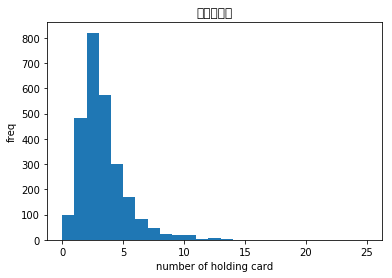

In [84]:
freq=[sum(train_df.loc[i]) for i in train_df.index]
plt.hist(freq, bins=np.arange(min(freq), max(freq)+1))
plt.xlabel('number of holding card')
plt.ylabel('freq')

plt.savefig('number_of_hold_card.jpg')
plt.show()

In [87]:
#pd.crosstab(index=freq,columns='count')
pd.value_counts(freq)

2.0     820
3.0     572
1.0     483
4.0     301
5.0     168
0.0      97
6.0      83
7.0      46
8.0      24
10.0     20
9.0      18
12.0      6
11.0      5
13.0      2
20.0      1
15.0      1
25.0      1
22.0      1
dtype: int64

In [ ]:
k=[1,3]
k.extend(list(range(5,31,5)))
precision_i=[]
time_i=[]
for i in [3]:
    precision_i.append(CF_Item_Based_Evaluate(train_df,i,5)[0]['Precision'])
    time_i.append(CF_Item_Based_Evaluate(train_df,i,5)[1])
print(precision_i)
print(time_i)

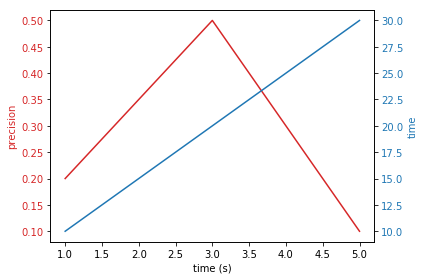

In [57]:
t = [1,3,5]
time_i = [10,20,30]
precision_i =[0.2,0.5,0.1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('precision', color=color)
ax1.plot(t, precision_i, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time', color=color)  # we already handled the x-label with ax1
ax2.plot(t, time_i, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [125]:
CF_Item_Based_Evaluate(train_df,5)

({'Precision': 0.10872027180067793, 'Hit': 0.5436013590033975},
 '--- 12.733741283416748 seconds ---')

In [25]:
CF_Item_Based_Evaluate(train_df,3)

({'Precision': 0.14508619604882256, 'Hit': 0.4352585881464704},
 '--- 22.2863028049469 seconds ---')

In [109]:
len(test_data[test_data['value']==1])

3161

#  User_Based

In [52]:
def CF_User_Based_Evaluate(train,NeighborN,TopN):
    #imput data type:my_card=['上海商銀-小小兵Bello回饋卡','中國信託-ANA聯名卡']
    start_time = time.time()
    traindata=train
    

    #user與其他user計算cosine相似度
    user_sim_array=cosine_similarity(train_df,train_df)
    user_rec_list={}
    for user in traindata.index:
        sim_value_sort=pd.Series(user_sim_array[user]).sort_values(ascending = False)
    # df_m2m = pd.DataFrame(cosine_similarity(df))
        topN_sim_user={}
        
        for idx,v in sim_value_sort.iteritems():
            if len(topN_sim_user)<NeighborN:     #topN_sim_user
                topN_sim_user[idx]=v  

        weighted_card_rec=np.zeros(len(traindata.columns))
        #相似權重相加
        for i in topN_sim_user:
            #print(i)
            weighted_card_rec+= traindata.loc[i]*topN_sim_user[i]
              
        #未持有的卡推薦  
        recommend_card=[]
        weighted_card_rec_sort=weighted_card_rec.sort_values(ascending=False)
        for card,value in weighted_card_rec_sort.iteritems():
                if value >0:
                    if train_df.loc[user,card]==0 and len(recommend_card) <TopN:
                                      recommend_card.append(card)
        user_rec_list[user]=recommend_card
    total_precision=0
    total_hit =0
    result={}

    for user in list(set(test_data['user'])):
        user_df=test_data[test_data['user']==user]
        user_df_hold=user_df[user_df['value']==1]['variable'].values
        hit=sum([1 for item in user_rec_list[user] if item in user_df_hold])
        precision=hit/TopN
        
        total_precision +=precision
        total_hit +=hit
    result['Precision']=total_precision/len(set(test_data['user']))
    result['Hit']=total_hit/len(set(test_data['user']))
    #exec_time="--- %s seconds ---" % (time.time() - start_time)
    exec_time=(time.time() - start_time)

    return result,exec_time
                    

In [54]:
k=[1,3]
k.extend(list(range(5,31,5)))
precision=[]
time_k=[]
for i in [3]:
    precision.append(CF_User_Based_Evaluate(train_df,i,5)[0]['Precision'])
    time_k.append(CF_User_Based_Evaluate(train_df,i,5)[1])
print(precision)
print(time_k)

[0.020536051340128383]
[58.985108613967896]


In [ ]:
t = [1,3,5]
time_u = [10,20,30]
precision_u =[0.2,0.5,0.1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('precision', color=color)
ax1.plot(t, precision_u, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time', color=color)  # we already handled the x-label with ax1
ax2.plot(t, time_u, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [128]:
CF_User_Based_Evaluate(train_df,100,5)

#train_df.loc[user,card]==0
#user_df=train_df[train_df['user']==1]
#user_df['中國信託-ANA聯名卡'] == 1

({'Precision': 0.10856927142317693, 'Hit': 0.5428463571158928},
 '--- 118.11028790473938 seconds ---')

In [130]:
CF_User_Based_Evaluate(train_df,5,5)

({'Precision': 0.033069082672706814, 'Hit': 0.16534541336353342},
 '--- 14.566324710845947 seconds ---')

In [22]:
CF_User_Based_Evaluate(train_df,5,3)

({'Precision': 0.04454511136277829, 'Hit': 0.13363533408833522},
 '--- 26.654712677001953 seconds ---')

# SVD_Evaluate

In [6]:
def SVD_Rec_Evaluate(user_matrix,k,TopN):
    start_time = time.time()
    train_df=user_matrix
    train_mx=train_df.as_matrix()
    user_mean=np.mean(train_mx,axis=1)
    user_array=train_mx-user_mean.reshape(-1,1)
    U, sigma, Vt = svds(user_array, k = k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = train_df.columns)
    #排除持有卡及推薦為持有卡
    user_rec_list={}
    for user in preds_df.index:
        recommend_card=[]
        card_rec_sort=preds_df.loc[user].sort_values(ascending=False)
        for card,value in card_rec_sort.iteritems():
                if value >0:
                    if train_df.loc[user,card]==0 and len(recommend_card) <TopN:
                                      recommend_card.append(card)
        user_rec_list[user]=recommend_card
    total_precision=0
    total_hit =0
    result={}

    for user in list(set(test_data['user'])):
        user_df=test_data[test_data['user']==user]
        user_df_hold=user_df[user_df['value']==1]['variable'].values
        hit=sum([1 for item in user_rec_list[user] if item in user_df_hold])
        precision=hit/TopN
        
        total_precision +=precision
        total_hit +=hit
    result['Precision']=total_precision/len(set(test_data['user']))
    result['Hit']=total_hit/len(set(test_data['user']))
    exec_time="--- %s seconds ---" % (time.time() - start_time)

    return result,exec_time
    
    

In [ ]:
def plot_time_prec(alg):
k=[1,3]
k.extend(list(range(5,31,5)))
precision_s=[]
time_s=[]
for i in [3]:
    precision.append(CF_User_Based_Evaluate(train_df,i,5)[0]['Precision'])
    time_k.append(CF_User_Based_Evaluate(train_df,i,5)[1])
print(precision_s)
print(time_s)

In [ ]:
t = [1,3,5]
time_s = [10,20,30]
precision_s =[0.2,0.5,0.1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('precision', color=color)
ax1.plot(t, precision_u, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('time', color=color)  # we already handled the x-label with ax1
ax2.plot(t, time_u, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# 準確度及運算時間畫圖

In [62]:
def plot_time_prec(alg,min_k,max_k,seg):
    k=[1,3]
    k.extend(list(range(min_k,max_k,seg)))
    precision_s=[]
    time_s=[]
    for i in k:
        precision_s.append(alg(train_df,i,5)[0]['Precision'])
        time_s.append(alg(train_df,i,5)[1])


    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('precision', color=color)
    ax1.plot(k, precision_s, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('time', color=color)  # we already handled the x-label with ax1
    ax2.plot(k, time_s, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    return plt.show()

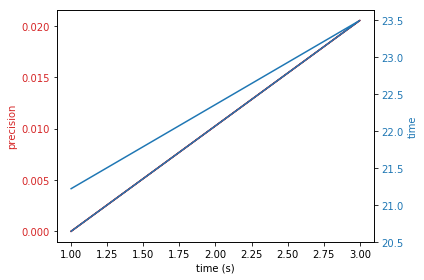

In [63]:
plot_time_prec(CF_User_Based_Evaluate,1,2,1)

In [ ]:
plot_time_prec

In [26]:
SVD_Rec_Evaluate(train_df,5,1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


({'Precision': 0.10124575311438139, 'Hit': 0.5062287655719139},
 '--- 28.526090383529663 seconds ---')

In [16]:
svd_result={}
for i in range(1,5):
    svd_result[i]=SVD_Rec_Evaluate(train_df,5,i)
svd_result

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


{1: ({'Precision': 0.10124575311438139, 'Hit': 0.5062287655719139},
  '--- 16.70376491546631 seconds ---'),
 2: ({'Precision': 0.09014722536806227, 'Hit': 0.4507361268403171},
  '--- 28.300856113433838 seconds ---'),
 3: ({'Precision': 0.07044167610418985, 'Hit': 0.3522083805209513},
  '--- 43.54500603675842 seconds ---'),
 4: ({'Precision': 0.0681766704416757, 'Hit': 0.3408833522083805},
  '--- 34.0753972530365 seconds ---')}

In [14]:
SVD_Rec_Evaluate(train_df,5,)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


({'Precision': 0.04696111740279389, 'Hit': 0.23480558701396753},
 '--- 14.768269777297974 seconds ---')

In [12]:
svd_result

[({'Precision': 0.011627029067572648, 'Hit': 0.05813514533786335},
  '--- 15.680037498474121 seconds ---'),
 ({'Precision': 0.009739524348810858, 'Hit': 0.04869762174405436},
  '--- 30.056437015533447 seconds ---'),
 ({'Precision': 0.00860702151755378, 'Hit': 0.04303510758776897},
  '--- 41.34556245803833 seconds ---'),
 ({'Precision': 0.006040015100037745, 'Hit': 0.03020007550018875},
  '--- 45.17659592628479 seconds ---'),
 ({'Precision': 0.004228010570026424, 'Hit': 0.021140052850132124},
  '--- 26.077417135238647 seconds ---'),
 ({'Precision': 0.002869007172517933, 'Hit': 0.014345035862589657},
  '--- 26.389355897903442 seconds ---'),
 ({'Precision': 0.002491506228765573, 'Hit': 0.01245753114382786},
  '--- 18.15139937400818 seconds ---')]